# Match glider observation with floats and ships profiles

In [11]:
import h5py
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt

In [4]:
#Simply change the working directory to the project directory

import os

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(current_dir)
os.chdir(parent_parent_dir)

# Now the working directory is set to the project directory
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\db_building


Write a function that save the .mat main table as a parquet file

In [16]:
def read_mat_write_parquet(filepath, save_folder, main_rep = 'gdat'):
    #Open the file with h5py library, it creates a group variable, which is similar as a dataset from a nc import
    file = h5py.File(filepath, 'r')
    #store the name of the file
    path_with_extension = os.path.basename(filepath)
    dataset_name, _ = os.path.splitext(path_with_extension)
    #extract the main repertory
    gdat = file[main_rep]
    #list all the variables inside the gdat group
    colnames = list(gdat.keys())
    #We then need to check which variable has the intended number of observation. The variables with the larger number of observations are the observations from the glider, metadata have less observations
    #Initaite empty array
    nobs = []
    #loop thgrough the variables to count the number of obs
    for i in colnames:
        temp_count = len(pd.Series(np.array(gdat[i])[0]))
        nobs.append(temp_count)
    nobs = np.array(nobs)

    #Select variables that have the max number of obs
    variables = np.where(nobs == max(nobs))[0]
    df_var = [colnames[i] for i in variables]

    #Initiate empty dataframe
    gdat_df = pd.DataFrame(index = range(max(nobs)), columns=df_var)

    #fill it with the values
    for var in df_var:
        gdat_df[var] = pd.Series(np.array(gdat[var])[0])
    table_final = pa.Table.from_pandas(gdat_df, preserve_index=False)
    parquet_name = save_folder + '/' + dataset_name + '.parquet'
    #write a parquet file
    pq.write_table(table_final, parquet_name)

Loop through the files

In [17]:
first_path = 'data/glider/custard_final/CUSTARD_330_high_res_full_dataset_gdat_array.mat'
parquet_folder = 'data/glider/custard_final/parquet_files'
read_mat_write_parquet(filepath = first_path, save_folder = parquet_folder)

Make a plot check

In [9]:
gdat_df = gdat_df.dropna(axis = 1, how = 'all')

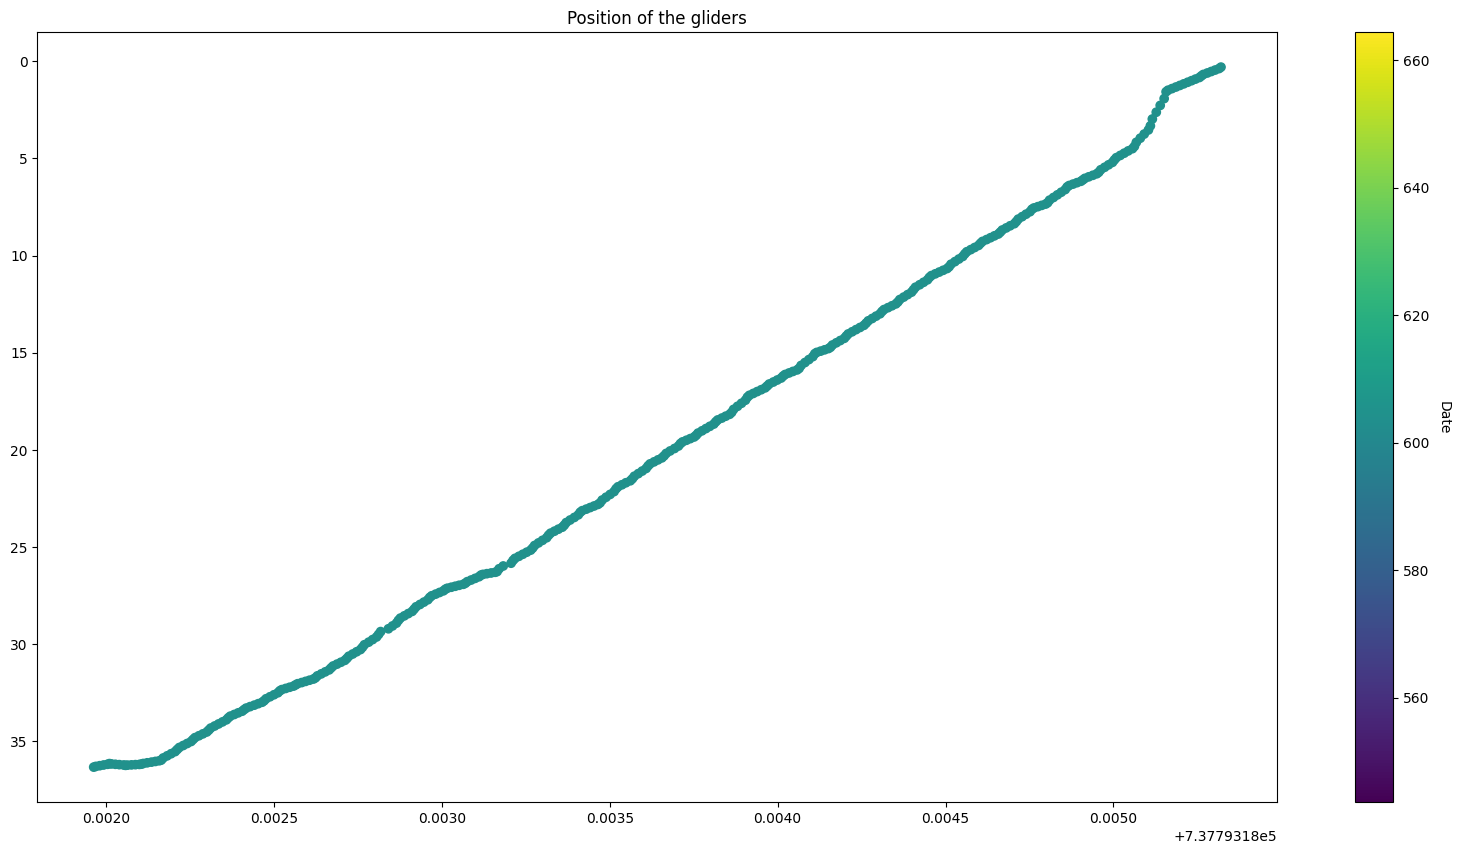

In [19]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

plt_df = gdat_df[gdat_df['drv_proIDs'] == 604]
sc = ax.scatter(plt_df['drv_mtime_sci'], plt_df['drv_depth_gli'], c = plt_df['drv_proIDs'])

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Date')
cbar.set_label('Date', rotation=270, labelpad=15)

#set the depth axis
plt.gca().invert_yaxis()

# set the plot title
ax.set_title("Position of the gliders")
plt.show()